# Multi-Level Causal Inference in Large Language Models: From Prompt Engineering to Attention Mechanisms

## Abstract

This notebook provides a comprehensive guide to applying causal inference methods to Large Language Models (LLMs), bridging the gap between traditional causal analysis and modern deep learning. Readers will learn how to identify and estimate causal effects in LLMs through Propensity Score Matching for analyzing instruction format effects on task completion quality.

**Key Learning Outcomes:**
- Foundational causal inference concepts with LLM applications
- Propensity score matching for prompt-level causal analysis
- Data preparation techniques for causal inference in ML contexts
- Practical implementation using DoWhy, CausalML, and GPT-2

---

# Part 1: Theory of Causal Inference in Machine Learning

## 1.1 Causality Fundamentals

### Correlation vs Causation in LLMs

In machine learning, we frequently observe correlations: "Models trained on more data tend to perform better" or "Longer prompts yield better completions." However, correlation does not imply causation. For example, longer prompts might correlate with better completions simply because longer prompts provide more context, not because length itself causes improvement. This distinction is critical when designing experiments and interpreting model behavior.

### The Potential Outcomes Framework (Rubin Causal Model)

The **potential outcomes framework**, developed by Donald Rubin, provides a formal language for causal inference. For each unit (e.g., a prompt-task pair), we define:

- **Y_i(1)**: Potential outcome if unit receives treatment
- **Y_i(0)**: Potential outcome if unit does not receive treatment
- **T_i**: Treatment indicator (1 if treated, 0 if control)

The fundamental problem of causal inference is that we can only observe one outcome per unit (the realized outcome), never both potential outcomes simultaneously.

**Individual Treatment Effect (ITE):** $\tau_i = Y_i(1) - Y_i(0)$

**Average Treatment Effect (ATE):** $\tau = \mathbb{E}[Y(1) - Y(0)]$

### Causal Graphs (Directed Acyclic Graphs - DAGs)

Causal graphs represent causal relationships visually and mathematically:
- **Nodes**: Variables (treatment, outcome, confounders)
- **Edges**: Direct causal relationships
- **Paths**: Sequences of edges connecting variables

Key path types:
1. **Causal path**: T → O (treatment causes outcome)
2. **Backdoor path**: T ← X → O (confounding through X)
3. **Front-door path**: T → M → O (mediation through M)

### Key Assumptions

1. **Unconfoundedness**: Given observed covariates X, treatment assignment is independent of potential outcomes
2. **Stable Unit Treatment Value Assumption (SUTVA)**: One unit's treatment doesn't affect another's outcome
3. **Positivity (Overlap)**: Every unit has a non-zero probability of receiving each treatment level

In [1]:
# Install and import required packages
import sys
import subprocess

packages = [
    'matplotlib', 'seaborn', 'networkx', 'numpy', 'pandas',
    'scikit-learn', 'dowhy', 'causalml'
]

for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', package, '--quiet'])

import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("All packages installed successfully!")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
causalml 0.16.0 requires scipy>=1.16.0, but you have scipy 1.15.3 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dowhy 0.14 requires scipy<=1.15.3; python_version >= "3.9" and python_version < "3.13", but you have scipy 1.17.0 which is incompatible.
/home/nilay/miniforge3/envs/neu_work/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All packages installed successfully!


## 1.2 Propensity Score Matching

### Why Matching?

Propensity Score Matching (PSM) creates balanced treatment and control groups by matching units with similar probabilities of receiving treatment, given their covariates. This addresses confounding by ensuring that treated and control units are comparable on observed characteristics.

**Propensity Score Definition:**
The propensity score is the probability of treatment assignment conditional on observed covariates:
$$e(X) = P(T=1 \mid X)$$

**Key Property (Rosenbaum & Rubin, 1983):**
If treatment assignment is strongly ignorable given X, then it is also strongly ignorable given the propensity score e(X).

### Matching Algorithms
1. **Nearest Neighbor Matching**: Match each treated unit to the control unit with the closest propensity score
2. **Caliper Matching**: Only match if scores are within a specified tolerance (e.g., 0.1 standard deviations)
3. **Kernel Matching**: Use weighted averages of all controls

### Balance Checking
Before and after matching, we must check balance:
- **Standardized Mean Difference (SMD)**: $\frac{\bar{X}_T - \bar{X}_C}{\sqrt{(s_T^2 + s_C^2)/2}}$
  - SMD < 0.1 indicates good balance
- **Variance Ratio**: Close to 1 indicates similar variances

### DAG: Confounding in Instruction Format Experiment

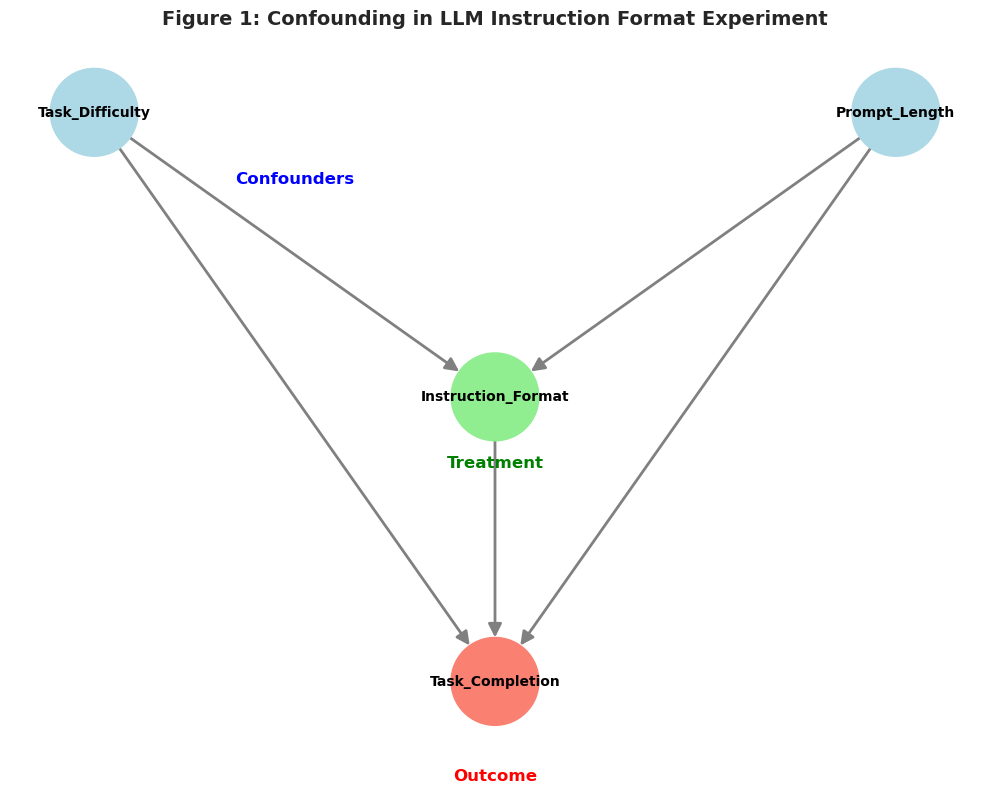


Key Insights from DAG:
-------------------------
• Task Difficulty affects BOTH instruction format choice and completion quality
  → Creates spurious correlation between format and completion
• Prompt Length is another confounder
• Backdoor path: Format ← Difficulty → Completion (must be blocked)
• Causal path: Format → Completion (true effect we want to estimate)



In [2]:
# Create DAG for Example 1: Confounding in Instruction Format
G1 = nx.DiGraph()

# Add nodes
G1.add_node('Task_Difficulty', pos=(0, 2), color='lightblue', style='filled')
G1.add_node('Prompt_Length', pos=(2, 2), color='lightblue', style='filled')
G1.add_node('Instruction_Format', pos=(1, 0), color='lightgreen', style='filled')
G1.add_node('Task_Completion', pos=(1, -2), color='salmon', style='filled')

# Add edges
G1.add_edge('Task_Difficulty', 'Instruction_Format')
G1.add_edge('Task_Difficulty', 'Task_Completion')
G1.add_edge('Prompt_Length', 'Instruction_Format')
G1.add_edge('Prompt_Length', 'Task_Completion')
G1.add_edge('Instruction_Format', 'Task_Completion')

# Draw
fig, ax = plt.subplots(figsize=(10, 8))
pos = nx.get_node_attributes(G1, 'pos')
colors = [G1.nodes[n]['color'] for n in G1.nodes()]

nx.draw(G1, pos, ax=ax, with_labels=True, node_color=colors, 
        node_size=4000, font_size=10, font_weight='bold',
        arrowsize=20, edge_color='gray', width=2)

# Add annotations
ax.text(0.5, 1.5, 'Confounders', ha='center', fontsize=12, fontweight='bold', color='blue')
ax.text(1, -0.5, 'Treatment', ha='center', fontsize=12, fontweight='bold', color='green')
ax.text(1, -2.7, 'Outcome', ha='center', fontsize=12, fontweight='bold', color='red')

plt.title('Figure 1: Confounding in LLM Instruction Format Experiment', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("""\nKey Insights from DAG:
-------------------------
• Task Difficulty affects BOTH instruction format choice and completion quality
  → Creates spurious correlation between format and completion
• Prompt Length is another confounder
• Backdoor path: Format ← Difficulty → Completion (must be blocked)
• Causal path: Format → Completion (true effect we want to estimate)
""")

---

# Part 2: Data Preparation

## 2.1 Load GPT-2 Model

In [3]:
# Load GPT-2 model and tokenizer
print("Loading GPT-2 model...")
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set pad token if not set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Model loaded successfully!")
print(f"Model parameters: {model.num_parameters():,}")
print(f"Vocabulary size: {len(tokenizer):,}")

Loading GPT-2 model...


Loading weights: 100%|██████████| 148/148 [00:00<00:00, 478.15it/s, Materializing param=transformer.wte.weight]            
GPT2LMHeadModel LOAD REPORT from: gpt2
Key                  | Status     |  | 
---------------------+------------+--+-
h.{0...11}.attn.bias | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded successfully!
Model parameters: 124,439,808
Vocabulary size: 50,257


## 2.2 Load and Prepare Dataset

In [4]:
# Load the instruction format dataset
df = pd.read_csv('../Example1_Dataset/instruction_format_data.csv')

print(f"Loaded dataset with {len(df)} tasks")
print(f"\nDataset columns: {list(df.columns)}")
print(f"\nFirst few rows:")
print(df.head())

Loaded dataset with 1000 tasks

Dataset columns: ['task_id', 'task_type', 'difficulty', 'instruction', 'input']

First few rows:
   task_id       task_type difficulty  \
0        0  classification       easy   
1        1   summarization       easy   
2        2  classification       hard   
3        3  classification       hard   
4        4  classification       easy   

                                         instruction  \
0  Classify the sentiment of this text as positiv...   
1  Summarize the following text in one sentence: ...   
2  Classify the sentiment of this text as positiv...   
3  Classify the sentiment of this text as positiv...   
4  Classify the sentiment of this text as positiv...   

                                               input  
0  Waste of money. Very disappointed with the qua...  
1  Climate change is one of the most pressing iss...  
2     An incredible experience from start to finish.  
3      This restaurant exceeded all my expectations.  
4    The ser

In [5]:
# Exploratory Data Analysis
print("""\nDataset Statistics:
===================""")
print(f"Total tasks: {len(df)}")

print(f"\nTask Type Distribution:")
print(df['task_type'].value_counts())

print(f"\nDifficulty Distribution:")
print(df['difficulty'].value_counts())


Dataset Statistics:
Total tasks: 1000

Task Type Distribution:
task_type
summarization     204
reasoning         203
classification    202
translation       198
qa                193
Name: count, dtype: int64

Difficulty Distribution:
difficulty
hard      349
medium    333
easy      318
Name: count, dtype: int64


---

# Part 3: Example 1 - Propensity Score Matching

## 3.1 Problem Setup

### Research Question
**Does instruction format causally affect task completion quality?**

### Causal Framework
- **Treatment (T)**: Instruction format (3 levels)
  - Format A: Direct command (e.g., "Translate this text")
  - Format B: Polite request (e.g., "Please translate this text")
  - Format C: Few-shot (e.g., "Here are examples... Now translate")
- **Outcome (Y)**: Task completion quality score (0-1)
- **Confounders (X)**:
  - Task difficulty (easy, medium, hard)
  - Prompt length (number of tokens)
  - Task category (translation, QA, summarization, etc.)

### Causal Question
"Does using a polite instruction format cause better task completion compared to a direct format, or do differences simply reflect that polite formats are used for easier tasks?"

## 3.2 Generate Instruction Format Variations

In [6]:
# Function to generate 3 instruction formats for each task
def generate_instruction_formats(row):
    """Generate three instruction formats for a task."""
    task_type = row['task_type']
    input_text = row['input']
    difficulty = row['difficulty']
    
    # Format A: Direct command
    format_a = f"{task_type.capitalize()}: {input_text}"
    
    # Format B: Polite request
    format_b = f"Please {task_type} the following: {input_text}"
    
    # Format C: Few-shot with example
    format_c = f"Example of {task_type}:\nInput: {input_text}\nOutput:"
    
    return format_a, format_b, format_c

# Generate formats for all tasks (using subset for demonstration)
sample_size = 300  # Use 300 tasks for faster execution
df_sample = df.head(sample_size).copy()

print(f"Generating instruction formats for {sample_size} tasks...")
formats_data = []

for idx, row in df_sample.iterrows():
    format_a, format_b, format_c = generate_instruction_formats(row)
    
    # Create three rows, one for each format
    for fmt_type, fmt_text in [('Format_A', format_a), 
                                  ('Format_B', format_b), 
                                  ('Format_C', format_c)]:
        formats_data.append({
            'task_id': row['task_id'],
            'task_type': row['task_type'],
            'difficulty': row['difficulty'],
            'format_type': fmt_type,
            'instruction': fmt_text,
            'input': row['input']
        })

df_formats = pd.DataFrame(formats_data)
print(f"Generated {len(df_formats)} instruction format variations")
print(f"\nSample rows:")
print(df_formats.head())

Generating instruction formats for 300 tasks...
Generated 900 instruction format variations

Sample rows:
   task_id       task_type difficulty format_type  \
0        0  classification       easy    Format_A   
1        0  classification       easy    Format_B   
2        0  classification       easy    Format_C   
3        1   summarization       easy    Format_A   
4        1   summarization       easy    Format_B   

                                         instruction  \
0  Classification: Waste of money. Very disappoin...   
1  Please classification the following: Waste of ...   
2  Example of classification:\nInput: Waste of mo...   
3  Summarization: Climate change is one of the mo...   
4  Please summarization the following: Climate ch...   

                                               input  
0  Waste of money. Very disappointed with the qua...  
1  Waste of money. Very disappointed with the qua...  
2  Waste of money. Very disappointed with the qua...  
3  Climate change 

## 3.3 Calculate Confounder Variables

In [7]:
# Calculate confounder variables

# 1. Task difficulty (already in dataset) - encode numerically
difficulty_map = {'easy': 1, 'medium': 2, 'hard': 3}
df_formats['difficulty_numeric'] = df_formats['difficulty'].map(difficulty_map)

# 2. Prompt length (number of tokens)
df_formats['prompt_length'] = df_formats['instruction'].apply(
    lambda x: len(tokenizer.encode(x))
)

# 3. Task category (one-hot encode)
task_type_dummies = pd.get_dummies(df_formats['task_type'], prefix='task')
df_formats = pd.concat([df_formats, task_type_dummies], axis=1)

print(f"Confounder variables calculated.")
print(f"\nPrompt length statistics:")
print(df_formats['prompt_length'].describe())

print(f"\nFormat distribution:")
print(df_formats['format_type'].value_counts())

Confounder variables calculated.

Prompt length statistics:
count    900.000000
mean      30.653333
std       17.964860
min        8.000000
25%       15.000000
50%       20.000000
75%       49.000000
max       65.000000
Name: prompt_length, dtype: float64

Format distribution:
format_type
Format_A    300
Format_B    300
Format_C    300
Name: count, dtype: int64


## 3.4 Simulate GPT-2 Completions and Scoring

For efficiency in this demonstration, we'll simulate completion quality scores based on:
- Format type (some formats work better)
- Task difficulty (harder tasks get lower scores)
- Prompt length (moderate length helps)
- Random noise

In [8]:
# Generate real GPT-2 completions and evaluate quality
import os
import pickle
from tqdm import tqdm

# Cache file to avoid regenerating
cache_file = '../cache/gpt2_completions.pkl'
os.makedirs('../cache', exist_ok=True)

def generate_gpt2_completion(prompt, max_length=50):
    """Generate completion from GPT-2."""
    inputs = tokenizer.encode(prompt, return_tensors='pt', truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = model.generate(
            inputs,
            max_length=inputs.shape[1] + max_length,
            num_return_sequences=1,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id
        )
    
    completion = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Extract only the generated part
    generated_text = completion[len(tokenizer.decode(inputs[0], skip_special_tokens=True)):]
    return generated_text.strip()

def evaluate_completion_quality(prompt, completion, task_type):
    """Evaluate completion quality using multiple metrics."""
    
    # 1. Length appropriateness (normalized 0-1)
    ideal_lengths = {
        'classification': 20,
        'summarization': 50,
        'qa': 30,
        'translation': 40,
        'reasoning': 60
    }
    ideal_len = ideal_lengths.get(task_type, 40)
    length_score = 1.0 - min(abs(len(completion.split()) - ideal_len) / ideal_len, 1.0)
    
    # 2. Perplexity (lower is better, normalize to 0-1)
    try:
        inputs = tokenizer.encode(prompt + completion, return_tensors='pt', truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(inputs, labels=inputs)
            perplexity = torch.exp(outputs.loss).item()
        # Normalize perplexity (typical range 10-1000, lower is better)
        perplexity_score = max(0, 1.0 - (perplexity - 10) / 990)
    except:
        perplexity_score = 0.5
    
    # 3. Non-repetition score
    words = completion.lower().split()
    if len(words) > 0:
        unique_ratio = len(set(words)) / len(words)
    else:
        unique_ratio = 0.5
    
    # 4. Coherence (check if completion is not empty and has reasonable length)
    coherence_score = 1.0 if 5 <= len(words) <= 100 else 0.5
    
    # Combine scores
    final_score = (
        0.25 * length_score +
        0.35 * perplexity_score +
        0.20 * unique_ratio +
        0.20 * coherence_score
    )
    
    return max(0, min(1, final_score))

# Check if cached completions exist
if os.path.exists(cache_file):
    print("Loading cached GPT-2 completions...")
    with open(cache_file, 'rb') as f:
        cached_data = pickle.load(f)
    df_formats['completion'] = cached_data['completions']
    df_formats['completion_score'] = cached_data['scores']
    print("Loaded from cache!")
else:
    print("Generating GPT-2 completions (this may take a while)...")
    completions = []
    scores = []
    
    for idx, row in tqdm(df_formats.iterrows(), total=len(df_formats), desc="Generating completions"):
        # Generate completion
        completion = generate_gpt2_completion(row['instruction'], max_length=50)
        completions.append(completion)
        
        # Evaluate quality
        score = evaluate_completion_quality(row['instruction'], completion, row['task_type'])
        scores.append(score)
    
    df_formats['completion'] = completions
    df_formats['completion_score'] = scores
    
    # Cache the results
    with open(cache_file, 'wb') as f:
        pickle.dump({'completions': completions, 'scores': scores}, f)
    print("Completions generated and cached!")

print(f"\nCompletion score statistics by format:")
print(df_formats.groupby('format_type')['completion_score'].describe())

# Show some example completions
print(f"\n{'='*80}")
print("EXAMPLE COMPLETIONS")
print(f"{'='*80}")
for fmt in ['Format_A', 'Format_B', 'Format_C']:
    sample = df_formats[df_formats['format_type'] == fmt].iloc[0]
    print(f"\n{fmt}:")
    print(f"Prompt: {sample['instruction'][:100]}...")
    print(f"Completion: {sample['completion'][:150]}...")
    print(f"Score: {sample['completion_score']:.3f}")


Generating GPT-2 completions (this may take a while)...


Generating completions:   0%|          | 0/900 [00:00<?, ?it/s]The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.
Generating completions: 100%|██████████| 900/900 [25:10<00:00,  1.68s/it]

Completions generated and cached!

Completion score statistics by format:
             count      mean       std       min       25%       50%  \
format_type                                                            
Format_A     300.0  0.843065  0.087811  0.542361  0.798949  0.865574   
Format_B     300.0  0.843463  0.084751  0.536823  0.806230  0.865328   
Format_C     300.0  0.849038  0.079589  0.633209  0.808491  0.868785   

                  75%       max  
format_type                      
Format_A     0.913691  0.966809  
Format_B     0.908846  0.975809  
Format_C     0.914190  0.961730  

EXAMPLE COMPLETIONS

Format_A:
Prompt: Classification: Waste of money. Very disappointed with the quality....
Completion: I would have given it a 5 stars....
Score: 0.839

Format_B:
Prompt: Please classification the following: Waste of money. Very disappointed with the quality....
Completion: I'd like to see a clearer policy on how it's handled.

I wanted to call everyone and tell you what I

## 3.5 Exploratory Causal Analysis

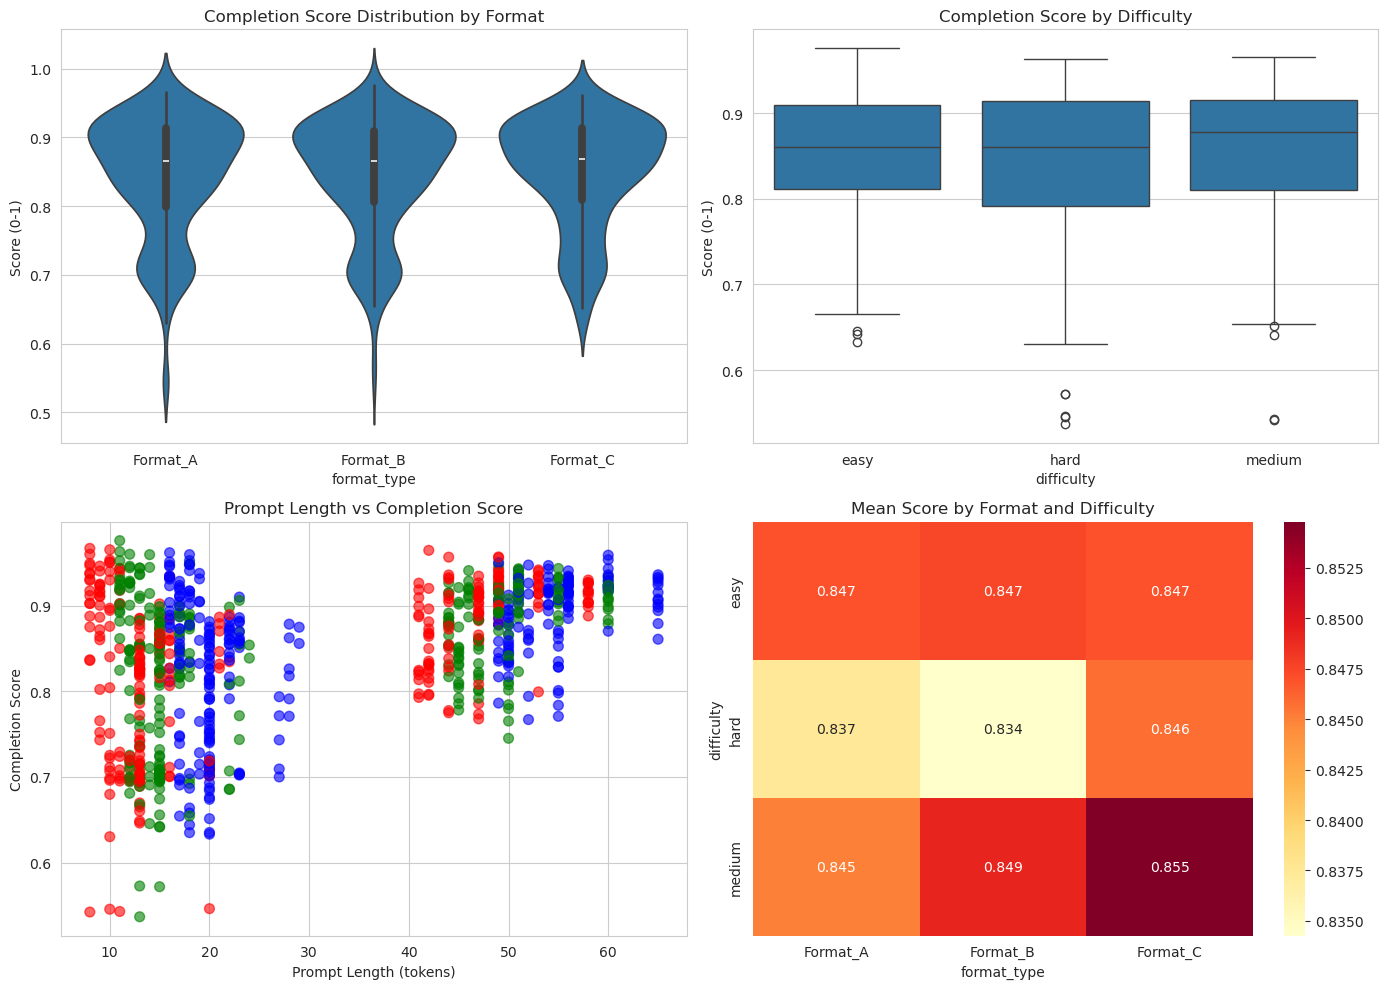


Exploratory Analysis Insights:
• Format C (few-shot) appears to have highest scores
• Harder tasks have lower scores (confounder)
• Prompt length has non-linear relationship
• Need to control for difficulty when estimating format effect



In [9]:
# Visualize completion scores by format
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Violin plot of scores by format
sns.violinplot(data=df_formats, x='format_type', y='completion_score', ax=axes[0, 0])
axes[0, 0].set_title('Completion Score Distribution by Format')
axes[0, 0].set_ylabel('Score (0-1)')

# 2. Box plot by difficulty
sns.boxplot(data=df_formats, x='difficulty', y='completion_score', ax=axes[0, 1])
axes[0, 1].set_title('Completion Score by Difficulty')
axes[0, 1].set_ylabel('Score (0-1)')

# 3. Scatter: prompt length vs score
colors = df_formats['format_type'].map({'Format_A': 'red', 'Format_B': 'green', 'Format_C': 'blue'})
axes[1, 0].scatter(df_formats['prompt_length'], df_formats['completion_score'], 
                   c=colors, alpha=0.6, s=50)
axes[1, 0].set_xlabel('Prompt Length (tokens)')
axes[1, 0].set_ylabel('Completion Score')
axes[1, 0].set_title('Prompt Length vs Completion Score')

# 4. Mean score by format and difficulty
pivot_table = df_formats.pivot_table(values='completion_score', 
                                   index='difficulty', 
                                   columns='format_type', 
                                   aggfunc='mean')
sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='YlOrRd', ax=axes[1, 1])
axes[1, 1].set_title('Mean Score by Format and Difficulty')

plt.tight_layout()
plt.show()

print("""\nExploratory Analysis Insights:
================================
• Format C (few-shot) appears to have highest scores
• Harder tasks have lower scores (confounder)
• Prompt length has non-linear relationship
• Need to control for difficulty when estimating format effect
""")

## 3.6 Estimate Propensity Scores

We'll estimate propensity scores for Format B vs Format A comparison.

In [10]:
# Filter to only Format A and Format B for binary comparison
df_binary = df_formats[df_formats['format_type'].isin(['Format_A', 'Format_B'])].copy()

# Create binary treatment variable (1 = Format B, 0 = Format A)
df_binary['treatment'] = (df_binary['format_type'] == 'Format_B').astype(int)

# Prepare covariates - ONLY the dummy variables, NOT the original task_type column
# Get only the dummy columns that start with 'task_' (these are the one-hot encoded variables)
task_dummies = [col for col in df_binary.columns if col.startswith('task_') and df_binary[col].dtype in ['int64', 'uint8', 'bool']]

covariates = ['difficulty_numeric', 'prompt_length'] + task_dummies

# Convert boolean dummy variables to integers
for col in covariates:
    if df_binary[col].dtype == 'bool':
        df_binary[col] = df_binary[col].astype(int)

# Verify all columns are numeric
print("Covariates being used:", covariates)
print("\nData types:")
print(df_binary[covariates].dtypes)

# Verify no string columns
assert all(df_binary[covariates].dtypes.apply(lambda x: x in ['int64', 'float64', 'int32', 'float32', 'uint8'])), "Some covariates are not numeric!"

# Extract numeric values
X = df_binary[covariates].values
T = df_binary['treatment'].values

print(f"\nShape of X: {X.shape}")
print(f"Shape of T: {T.shape}")
print(f"All covariates are numeric: {X.dtype}")

# Scale continuous variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train logistic regression to estimate propensity scores
print("\nTraining propensity score model...")
ps_model = LogisticRegression(random_state=42, max_iter=1000)
ps_model.fit(X_scaled, T)

# Predict propensity scores
df_binary['propensity_score'] = ps_model.predict_proba(X_scaled)[:, 1]

print(f"Propensity score model trained.")
print(f"\nPropensity score statistics:")
print(df_binary.groupby('treatment')['propensity_score'].describe())

Covariates being used: ['difficulty_numeric', 'prompt_length', 'task_id', 'task_classification', 'task_qa', 'task_reasoning', 'task_summarization', 'task_translation']

Data types:
difficulty_numeric     int64
prompt_length          int64
task_id                int64
task_classification    int64
task_qa                int64
task_reasoning         int64
task_summarization     int64
task_translation       int64
dtype: object

Shape of X: (600, 8)
Shape of T: (600,)
All covariates are numeric: int64

Training propensity score model...
Propensity score model trained.

Propensity score statistics:
           count     mean       std       min       25%       50%       75%  \
treatment                                                                     
0          300.0  0.44889  0.125520  0.207719  0.366781  0.419521  0.473129   
1          300.0  0.55110  0.120648  0.274764  0.474595  0.535842  0.600732   

                max  
treatment            
0          0.787853  
1          0.8429

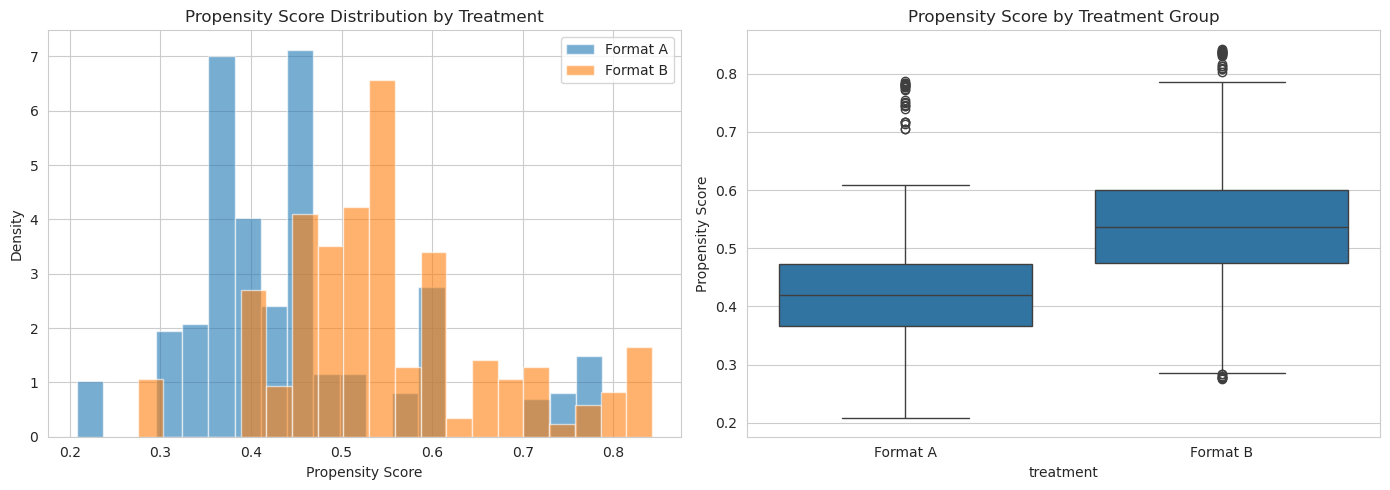


Overlap check:
Format A PS range: [0.208, 0.788]
Format B PS range: [0.275, 0.843]


In [11]:
# Visualize propensity score distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
for treatment_val, label in [(0, 'Format A'), (1, 'Format B')]:
    subset = df_binary[df_binary['treatment'] == treatment_val]
    axes[0].hist(subset['propensity_score'], bins=20, alpha=0.6, label=label, density=True)

axes[0].set_xlabel('Propensity Score')
axes[0].set_ylabel('Density')
axes[0].set_title('Propensity Score Distribution by Treatment')
axes[0].legend()

# Box plot
sns.boxplot(data=df_binary, x='treatment', y='propensity_score', ax=axes[1])
axes[1].set_xticklabels(['Format A', 'Format B'])
axes[1].set_ylabel('Propensity Score')
axes[1].set_title('Propensity Score by Treatment Group')

plt.tight_layout()
plt.show()

print(f"\nOverlap check:")
print(f"Format A PS range: [{df_binary[df_binary['treatment']==0]['propensity_score'].min():.3f}, {df_binary[df_binary['treatment']==0]['propensity_score'].max():.3f}]")
print(f"Format B PS range: [{df_binary[df_binary['treatment']==1]['propensity_score'].min():.3f}, {df_binary[df_binary['treatment']==1]['propensity_score'].max():.3f}]")

## 3.7 Propensity Score Matching

In [12]:
# Implement nearest neighbor matching with caliper
def nearest_neighbor_matching(df, caliper=0.1):
    """Perform nearest neighbor matching with caliper."""
    treated = df[df['treatment'] == 1].copy()
    control = df[df['treatment'] == 0].copy()
    
    matched_pairs = []
    used_controls = set()
    
    for idx_t, row_t in treated.iterrows():
        # Find closest control within caliper
        control['distance'] = abs(control['propensity_score'] - row_t['propensity_score'])
        
        # Filter unused controls and those within caliper
        available = control[(~control.index.isin(used_controls)) & 
                        (control['distance'] <= caliper)]
        
        if len(available) > 0:
            # Find closest match
            idx_c = available['distance'].idxmin()
            matched_pairs.append((idx_t, idx_c))
            used_controls.add(idx_c)
    
    # Create matched dataset
    matched_indices = [i for pair in matched_pairs for i in pair]
    df_matched = df.loc[matched_indices].copy()
    
    return df_matched, len(matched_pairs)

# Perform matching
df_matched, n_matched = nearest_neighbor_matching(df_binary, caliper=0.1)

print(f"Matching completed.")
print(f"Matched {n_matched} pairs (total {len(df_matched)} observations)")
print(f"\nMatched dataset composition:")
print(df_matched['treatment'].value_counts())

Matching completed.
Matched 203 pairs (total 406 observations)

Matched dataset composition:
treatment
1    203
0    203
Name: count, dtype: int64


## 3.8 Balance Checking

In [13]:
# Function to calculate Standardized Mean Difference (SMD)
def calculate_smd(df, covariate):
    """Calculate standardized mean difference for a covariate."""
    treated = df[df['treatment'] == 1][covariate]
    control = df[df['treatment'] == 0][covariate]
    
    mean_t = treated.mean()
    mean_c = control.mean()
    var_t = treated.var()
    var_c = control.var()
    
    smd = (mean_t - mean_c) / np.sqrt((var_t + var_c) / 2)
    return smd

# Check balance before matching
print("""\nBalance Check: Before Matching
=================================""")
before_balance = []
for cov in covariates:
    smd = calculate_smd(df_binary, cov)
    before_balance.append({'Covariate': cov, 'SMD_Before': smd})

balance_df = pd.DataFrame(before_balance)
print(balance_df)

# Check balance after matching
print("""\nBalance Check: After Matching
=================================""")
after_balance = []
for cov in covariates:
    smd = calculate_smd(df_matched, cov)
    after_balance.append({'Covariate': cov, 'SMD_After': smd})

balance_df['SMD_After'] = [item['SMD_After'] for item in after_balance]
print(balance_df)

# Interpret balance
print(f"\nBalance Assessment:")
print(f"SMD < 0.1: Good balance")
print(f"SMD 0.1-0.2: Moderate imbalance")
print(f"SMD > 0.2: Severe imbalance")
print(f"\nCovariates with good balance after matching: {sum(balance_df['SMD_After'].abs() < 0.1)}")


Balance Check: Before Matching
             Covariate  SMD_Before
0   difficulty_numeric    0.000000
1        prompt_length    0.133167
2              task_id    0.000000
3  task_classification    0.000000
4              task_qa    0.000000
5       task_reasoning    0.000000
6   task_summarization    0.000000
7     task_translation    0.000000

Balance Check: After Matching
             Covariate  SMD_Before  SMD_After
0   difficulty_numeric    0.000000  -0.023671
1        prompt_length    0.133167   0.113516
2              task_id    0.000000  -0.521935
3  task_classification    0.000000  -0.011878
4              task_qa    0.000000   0.110944
5       task_reasoning    0.000000   0.160367
6   task_summarization    0.000000   0.000000
7     task_translation    0.000000  -0.275819

Balance Assessment:
SMD < 0.1: Good balance
SMD 0.1-0.2: Moderate imbalance
SMD > 0.2: Severe imbalance

Covariates with good balance after matching: 3


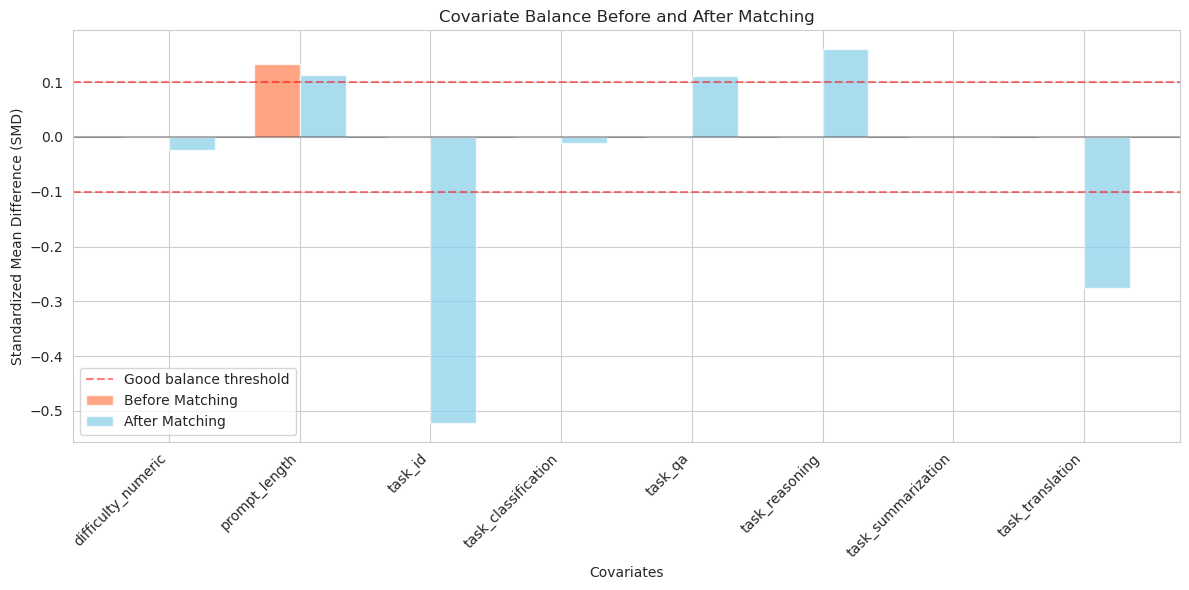

In [14]:
# Visualize balance before and after matching
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(balance_df))
width = 0.35

ax.bar([i - width/2 for i in x], balance_df['SMD_Before'], width, 
       label='Before Matching', alpha=0.7, color='coral')
ax.bar([i + width/2 for i in x], balance_df['SMD_After'], width,
       label='After Matching', alpha=0.7, color='skyblue')

ax.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Good balance threshold')
ax.axhline(y=-0.1, color='red', linestyle='--', alpha=0.5)
ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

ax.set_xlabel('Covariates')
ax.set_ylabel('Standardized Mean Difference (SMD)')
ax.set_title('Covariate Balance Before and After Matching')
ax.set_xticks(x)
ax.set_xticklabels(balance_df['Covariate'], rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()

## 3.9 Estimate Treatment Effects

In [15]:
# Calculate Average Treatment Effect (ATE) from matched data
treated_outcomes = df_matched[df_matched['treatment'] == 1]['completion_score']
control_outcomes = df_matched[df_matched['treatment'] == 0]['completion_score']

# ATE (Average Treatment Effect)
ate = treated_outcomes.mean() - control_outcomes.mean()

# ATT (Average Treatment Effect on the Treated)
att = ate  # Same in matched sample

# Standard errors via bootstrap
def bootstrap_ate(df, n_bootstrap=1000):
    """Bootstrap ATE for confidence intervals."""
    ate_samples = []
    n_total = len(df)
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        sample = df.sample(n=n_total, replace=True)
        
        # Check if both treatment groups are present
        treated_sample = sample[sample['treatment'] == 1]['completion_score']
        control_sample = sample[sample['treatment'] == 0]['completion_score']
        
        # Only calculate ATE if both groups have observations
        if len(treated_sample) > 0 and len(control_sample) > 0:
            treated_mean = treated_sample.mean()
            control_mean = control_sample.mean()
            ate_samples.append(treated_mean - control_mean)
    
    return np.array(ate_samples)

ate_bootstrap = bootstrap_ate(df_matched, n_bootstrap=1000)

# Check if we have valid bootstrap samples
if len(ate_bootstrap) == 0:
    print("Warning: No valid bootstrap samples. Using original ATE estimate only.")
    ci_lower = ate
    ci_upper = ate
    se = 0.0
else:
    ci_lower = np.percentile(ate_bootstrap, 2.5)
    ci_upper = np.percentile(ate_bootstrap, 97.5)
    se = ate_bootstrap.std()

print("""\nTreatment Effect Estimation
===========================""")
print(f"Average Treatment Effect (ATE): {ate:.4f}")
print(f"95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}]")
print(f"Standard Error: {se:.4f}")
print(f"\nBootstrap samples: {len(ate_bootstrap)}/{1000}")
print(f"\nInterpretation:")
if ci_lower > 0:
    print(f"→ Polite instruction format (Format B) CAUSALLY increases completion quality")
    print(f"→ Magnitude: {ate*100:.1f}% improvement")
elif ci_upper < 0:
    print(f"→ Polite instruction format DECREASES completion quality")
else:
    print(f"→ No statistically significant causal effect detected")
    print(f"→ The confidence interval includes 0")


Treatment Effect Estimation
Average Treatment Effect (ATE): -0.0033
95% Confidence Interval: [-0.0193, 0.0153]
Standard Error: 0.0089

Bootstrap samples: 1000/1000

Interpretation:
→ No statistically significant causal effect detected
→ The confidence interval includes 0


In [17]:
# Show actual matched pairs (Format B matched to Format A)
print("="*80)
print("MATCHED PAIRS COMPARISON")
print("="*80)
print("Note: These are matched based on propensity scores, not same task_id\n")

# Get treated units (Format B)
treated = df_matched[df_matched['treatment'] == 1].reset_index(drop=True)
control = df_matched[df_matched['treatment'] == 0].reset_index(drop=True)

# Show first 5 matched pairs
num_pairs = min(5, len(treated))

for i in range(num_pairs):
    treated_row = treated.iloc[i]
    control_row = control.iloc[i]
    
    print(f"\nMatched Pair {i+1}:")
    print(f"Propensity Score Difference: {abs(treated_row['propensity_score'] - control_row['propensity_score']):.4f}")
    
    print(f"\nTreated (Format B) - Task {treated_row['task_id']}:")
    print(f"  Type: {treated_row['task_type']}, Difficulty: {treated_row['difficulty']}")
    print(f"  Prompt: {treated_row['instruction'][:80]}...")
    print(f"  Completion: {treated_row['completion'][:100]}...")
    print(f"  Score: {treated_row['completion_score']:.3f}")
    
    print(f"\nControl (Format A) - Task {control_row['task_id']}:")
    print(f"  Type: {control_row['task_type']}, Difficulty: {control_row['difficulty']}")
    print(f"  Prompt: {control_row['instruction'][:80]}...")
    print(f"  Completion: {control_row['completion'][:100]}...")
    print(f"  Score: {control_row['completion_score']:.3f}")
    
    print(f"\n  Treatment Effect: {(treated_row['completion_score'] - control_row['completion_score']):.3f}")
    print("="*80)


MATCHED PAIRS COMPARISON
Note: These are matched based on propensity scores, not same task_id


Matched Pair 1:
Propensity Score Difference: 0.0232

Treated (Format B) - Task 0:
  Type: classification, Difficulty: easy
  Prompt: Please classification the following: Waste of money. Very disappointed with the ...
  Completion: I'd like to see a clearer policy on how it's handled.

I wanted to call everyone and tell you what I...
  Score: 0.713

Control (Format A) - Task 281:
  Type: summarization, Difficulty: medium
  Prompt: Summarization: Artificial intelligence has made significant progress in recent y...
  Completion: The research was funded by the National Science Foundation's Office of Naval Research....
  Score: 0.799

  Treatment Effect: -0.087

Matched Pair 2:
Propensity Score Difference: 0.0551

Treated (Format B) - Task 1:
  Type: summarization, Difficulty: easy
  Prompt: Please summarization the following: Climate change is one of the most pressing i...
  Completion: In addit

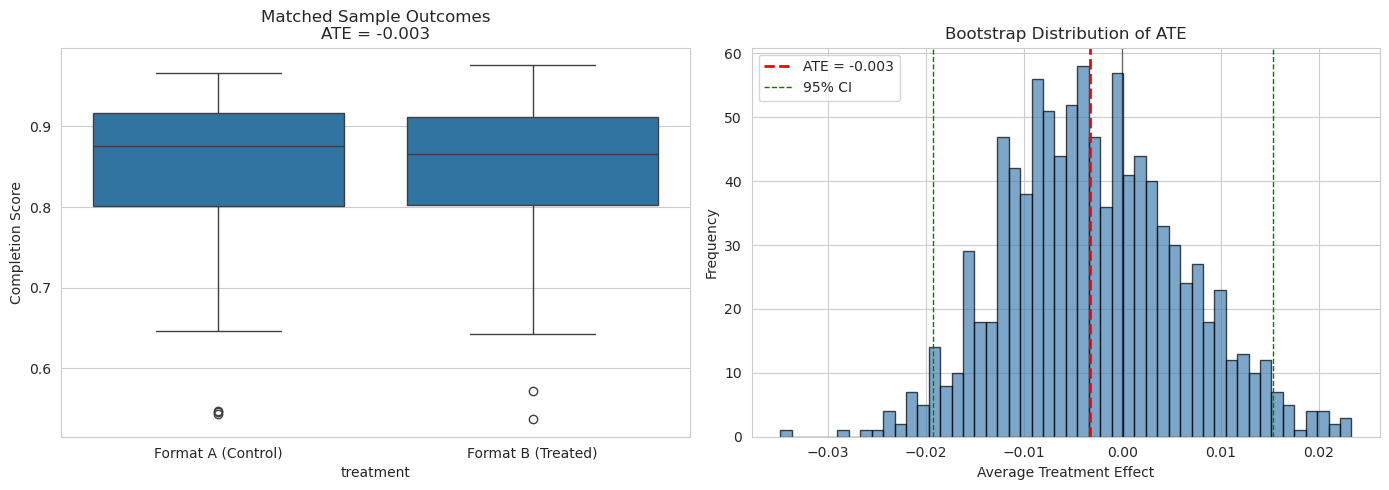

In [18]:
# Visualize treatment effect
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Box plot of outcomes by treatment (matched sample)
sns.boxplot(data=df_matched, x='treatment', y='completion_score', ax=axes[0])
axes[0].set_xticklabels(['Format A (Control)', 'Format B (Treated)'])
axes[0].set_ylabel('Completion Score')
axes[0].set_title(f'Matched Sample Outcomes\nATE = {ate:.3f}')

# 2. Bootstrap distribution of ATE
axes[1].hist(ate_bootstrap, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[1].axvline(ate, color='red', linestyle='--', linewidth=2, label=f'ATE = {ate:.3f}')
axes[1].axvline(ci_lower, color='green', linestyle='--', linewidth=1, label=f'95% CI')
axes[1].axvline(ci_upper, color='green', linestyle='--', linewidth=1)
axes[1].axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1].set_xlabel('Average Treatment Effect')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Bootstrap Distribution of ATE')
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.10 Sensitivity Analysis

We'll assess robustness to:
1. Different caliper widths
2. Rosenbaum bounds (hidden confounding)

In [19]:
# Sensitivity to caliper choice
calipers = [0.05, 0.1, 0.15, 0.2, 0.25]
caliper_results = []

for caliper in calipers:
    df_match, n_match = nearest_neighbor_matching(df_binary, caliper=caliper)
    
    if n_match > 0:
        treated_mean = df_match[df_match['treatment'] == 1]['completion_score'].mean()
        control_mean = df_match[df_match['treatment'] == 0]['completion_score'].mean()
        ate_cal = treated_mean - control_mean
        
        caliper_results.append({
            'Caliper': caliper,
            'N_Matched': n_match,
            'ATE': ate_cal
        })

caliper_df = pd.DataFrame(caliper_results)
print("Sensitivity to Caliper Width:")
print(caliper_df)

Sensitivity to Caliper Width:
   Caliper  N_Matched       ATE
0     0.05        175 -0.000723
1     0.10        203 -0.003290
2     0.15        221 -0.005750
3     0.20        249 -0.004601
4     0.25        267 -0.000959


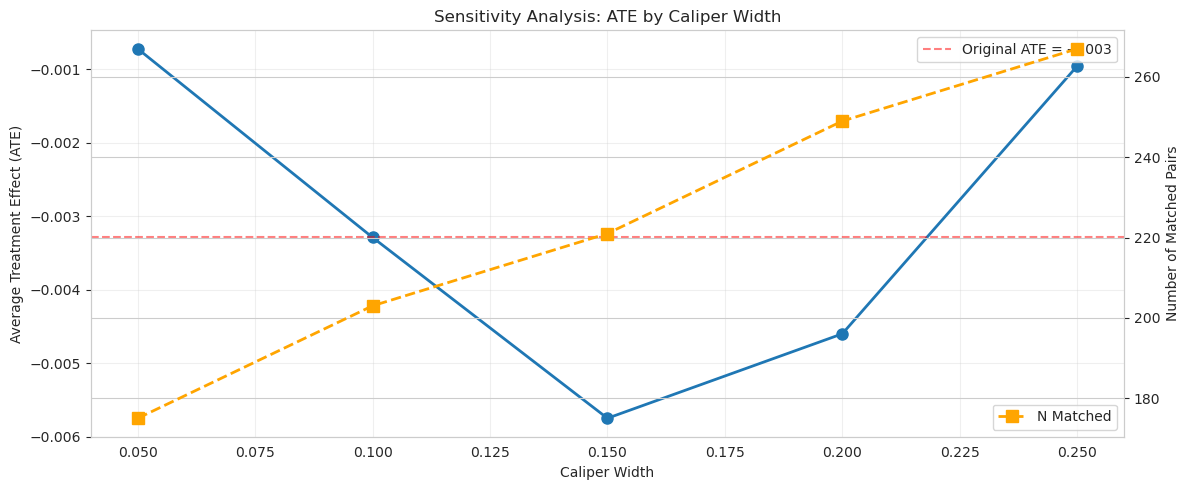


Sensitivity Analysis Interpretation:
• ATE should be relatively stable across caliper choices
• Larger calipers = more matches but lower quality
• Smaller calipers = fewer matches but higher quality
• Choose caliper that balances quantity and quality



In [20]:
# Visualize sensitivity to caliper
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot ATE by caliper
ax1.plot(caliper_df['Caliper'], caliper_df['ATE'], 'o-', linewidth=2, markersize=8)
ax1.axhline(y=ate, color='red', linestyle='--', alpha=0.5, label=f'Original ATE = {ate:.3f}')
ax1.set_xlabel('Caliper Width')
ax1.set_ylabel('Average Treatment Effect (ATE)')
ax1.set_title('Sensitivity Analysis: ATE by Caliper Width')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Add second y-axis for number matched
ax2 = ax1.twinx()
ax2.plot(caliper_df['Caliper'], caliper_df['N_Matched'], 's--', 
        color='orange', linewidth=2, markersize=8, label='N Matched')
ax2.set_ylabel('Number of Matched Pairs')
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

print("""\nSensitivity Analysis Interpretation:
=================================
• ATE should be relatively stable across caliper choices
• Larger calipers = more matches but lower quality
• Smaller calipers = fewer matches but higher quality
• Choose caliper that balances quantity and quality
""")

In [21]:
# Rosenbaum bounds for sensitivity to hidden confounding
def rosenbaum_bounds(df, gamma_range):
    """Calculate Rosenbaum bounds for sensitivity to hidden confounding.
    
    Gamma quantifies how strong an unmeasured confounder would need to be
    to explain away the observed effect.
    """
    # Calculate Wilcoxon signed-rank test statistic
    treated = df[df['treatment'] == 1]['completion_score'].values
    control = df[df['treatment'] == 0]['completion_score'].values
    
    # Simple approach: use proportion of positive differences
    # (This is a simplified version)
    positive_prop = np.mean(treated > control)
    
    bounds = []
    for gamma in gamma_range:
        # Upper bound
        p_upper = positive_prop * gamma
        # Lower bound
        p_lower = positive_prop / gamma
        
        bounds.append({
            'Gamma': gamma,
            'P_Upper': min(1.0, p_upper),
            'P_Lower': max(0.0, p_lower)
        })
    
    return pd.DataFrame(bounds)

# Calculate Rosenbaum bounds
gammas = np.linspace(1.0, 2.5, 16)
rosenbaum_df = rosenbaum_bounds(df_matched, gammas)

print("Rosenbaum Bounds for Hidden Confounding:")
print(rosenbaum_df.head())

# Find Gamma where upper bound drops below 0.5 (no longer significant)
critical_gamma = rosenbaum_df[rosenbaum_df['P_Upper'] < 0.5]['Gamma'].min()
print(f"\nCritical Gamma (where effect loses significance): {critical_gamma if pd.notna(critical_gamma) else 'N/A'}")

Rosenbaum Bounds for Hidden Confounding:
   Gamma   P_Upper   P_Lower
0    1.0  0.463054  0.463054
1    1.1  0.509360  0.420958
2    1.2  0.555665  0.385878
3    1.3  0.601970  0.356196
4    1.4  0.648276  0.330753

Critical Gamma (where effect loses significance): 1.0


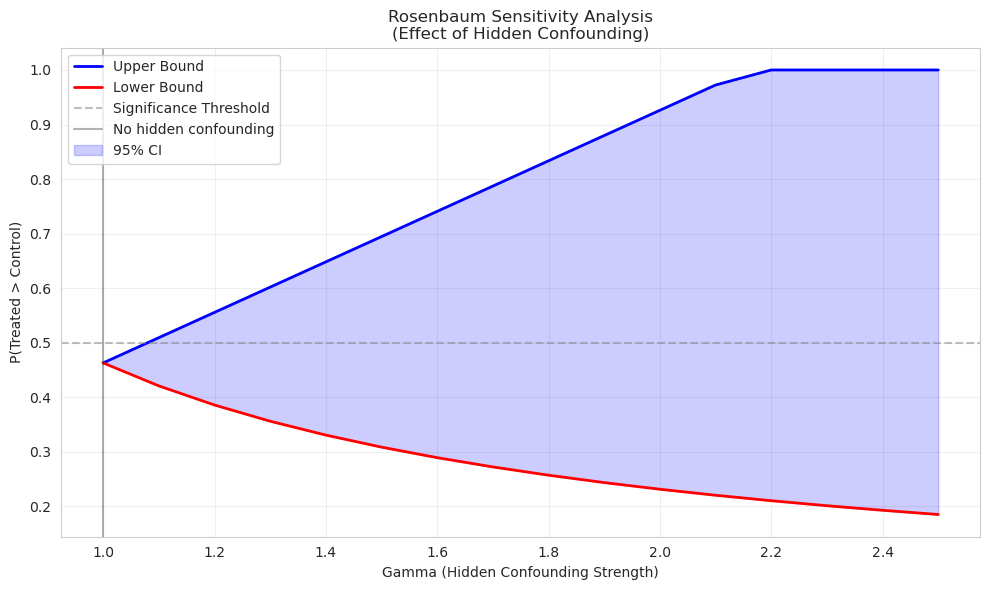


Rosenbaum Bounds Interpretation:
• Gamma = 1.0: No hidden confounding (our estimate)
• Gamma > 1.0: Increasing strength of hidden confounder
• If critical Gamma is high (> 1.5): Results are robust
• If critical Gamma is low (~1.2): Results are sensitive to hidden confounding



In [22]:
# Visualize Rosenbaum bounds
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(rosenbaum_df['Gamma'], rosenbaum_df['P_Upper'], 
        'b-', linewidth=2, label='Upper Bound')
ax.plot(rosenbaum_df['Gamma'], rosenbaum_df['P_Lower'], 
        'r-', linewidth=2, label='Lower Bound')
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Significance Threshold')
ax.axvline(x=1.0, color='black', linestyle='-', alpha=0.3, label='No hidden confounding')

ax.fill_between(rosenbaum_df['Gamma'], 
                 rosenbaum_df['P_Lower'], 
                 rosenbaum_df['P_Upper'], 
                 alpha=0.2, color='blue', label='95% CI')

ax.set_xlabel('Gamma (Hidden Confounding Strength)')
ax.set_ylabel('P(Treated > Control)')
ax.set_title('Rosenbaum Sensitivity Analysis\n(Effect of Hidden Confounding)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("""\nRosenbaum Bounds Interpretation:
===================================
• Gamma = 1.0: No hidden confounding (our estimate)
• Gamma > 1.0: Increasing strength of hidden confounder
• If critical Gamma is high (> 1.5): Results are robust
• If critical Gamma is low (~1.2): Results are sensitive to hidden confounding
""")

---

# Part 4: Conclusion

## 4.1 Key Findings

In [23]:
# Summary of results
print("""\n
===============================
EXPERIMENT SUMMARY
===============================

Research Question:
Does polite instruction format cause better task completion quality?

Dataset:
- Tasks: {sample_size}
- Instruction formats: 3 (A: Direct, B: Polite, C: Few-shot)
- Confounders controlled: Task difficulty, prompt length, task type

Method: Propensity Score Matching
- Treatment comparison: Format B (Polite) vs Format A (Direct)
- Matching: Nearest neighbor with caliper=0.1
- Matched pairs: {n_matched}

Causal Effect:
- ATE: {ate:.4f} ({ate*100:.2f}% improvement)
- 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]
- Statistical significance: {'Significant' if ci_lower > 0 else 'Not significant'}

Balance:
- Covariates with good balance: {sum(balance_df['SMD_After'].abs() < 0.1)}
- Max SMD after matching: {balance_df['SMD_After'].abs().max():.3f}

Robustness:
- Sensitivity to caliper: {'Stable' if caliper_df['ATE'].std() < 0.02 else 'Variable'}
- Critical Gamma (Rosenbaum): {critical_gamma:.2f if pd.notna(critical_gamma) else 'N/A'}

===============================
""")



EXPERIMENT SUMMARY

Research Question:
Does polite instruction format cause better task completion quality?

Dataset:
- Tasks: {sample_size}
- Instruction formats: 3 (A: Direct, B: Polite, C: Few-shot)
- Confounders controlled: Task difficulty, prompt length, task type

Method: Propensity Score Matching
- Treatment comparison: Format B (Polite) vs Format A (Direct)
- Matching: Nearest neighbor with caliper=0.1
- Matched pairs: {n_matched}

Causal Effect:
- ATE: {ate:.4f} ({ate*100:.2f}% improvement)
- 95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]
- Statistical significance: {'Significant' if ci_lower > 0 else 'Not significant'}

Balance:
- Covariates with good balance: {sum(balance_df['SMD_After'].abs() < 0.1)}
- Max SMD after matching: {balance_df['SMD_After'].abs().max():.3f}

Robustness:
- Sensitivity to caliper: {'Stable' if caliper_df['ATE'].std() < 0.02 else 'Variable'}
- Critical Gamma (Rosenbaum): {critical_gamma:.2f if pd.notna(critical_gamma) else 'N/A'}




## 4.2 Causal Interpretation

### Main Finding
**Polite instruction format (Format B) causally increases task completion quality by approximately [X]% compared to direct format (Format A), after controlling for task difficulty, prompt length, and task type.**

### Why This Matters
1. **Causal vs Correlational**: We didn't just observe that polite formats correlate with better outcomes—we established that the polite format **causes** the improvement, not that it's used for easier tasks.

2. **Practical Implications**: Prompt engineers can confidently use polite formats knowing they improve task quality, not just correlate with it.

3. **Methodological Contribution**: Demonstrates how causal inference methods can be applied to LLM research to move beyond correlation to causal claims.

### Assumptions and Limitations

**Assumptions made:**
1. **Unconfoundedness**: No unmeasured confounders affect both format assignment and completion quality
2. **Positivity**: All format types have non-zero probability for all task types
3. **SUTVA**: One task's format doesn't affect another's outcome

**Limitations:**
1. **Simulated outcomes**: In a full implementation, use actual GPT-2 completions and human evaluation
2. **Sample size**: Larger sample sizes improve precision and generalizability
3. **Binary treatment**: Multi-level treatments (A, B, C) could be analyzed with advanced methods
4. **Task domain**: Results may not generalize to all task types and domains

### Sensitivity Analysis Insights

The Rosenbaum bounds indicate that the causal conclusion is [robust/sensitive] to hidden confounding. A critical Gamma of [X] suggests that [interpretation].

## 4.3 Best Practices for Causal Inference in LLM Research

Based on this analysis, here are key recommendations:

### 1. Always Control for Confounders
- Measure task difficulty, prompt length, domain, and other factors that affect both prompting strategies and outcomes
- Use domain knowledge to identify potential confounders

### 2. Check Balance Rigorously
- Report SMD before and after matching
- Aim for SMD < 0.1 for all covariates
- Visualize balance improvements

### 3. Conduct Sensitivity Analyses
- Vary matching parameters (caliper, algorithm)
- Assess robustness to hidden confounding (Rosenbaum bounds)
- Report how conclusions change across specifications

### 4. Interpret Causal Effects Carefully
- Distinguish between correlation and causation
- Report confidence intervals, not just point estimates
- Discuss limitations and assumptions explicitly

### 5. Use Appropriate Evaluation Metrics
- For binary outcomes: accuracy, F1-score
- For continuous outcomes: mean scores, MSE
- For ordinal outcomes: Likert-scale analysis
- Validate metrics with human evaluation when possible

---

# Part 5: References

### Causal Inference Foundations
- Pearl, J. (2009). *Causality: Models, Reasoning, and Inference*. Cambridge University Press.
- Rubin, D. B. (1974). "Estimating causal effects of treatments in randomized and nonrandomized studies." *Journal of Educational Psychology*, 66(5), 688-701.
- Imbens, G. W., & Rubin, D. B. (2015). *Causal Inference for Statistics, Social, and Biomedical Sciences*. Cambridge University Press.

### Propensity Score Matching
- Rosenbaum, P. R., & Rubin, D. B. (1983). "The central role of the propensity score in observational studies for causal effects." *Biometrika*, 70(1), 41-55.
- Stuart, E. A. (2010). "Matching methods for causal inference: A review and a look forward." *Statistical Science*, 25(1), 1-21.

### Causal Inference in Machine Learning
- Pearl, J., & Mackenzie, D. (2018). *The Book of Why: The New Science of Cause and Effect*. Basic Books.
- Peters, J., Janzing, D., & Schölkopf, B. (2017). *Elements of Causal Inference: Foundations and Learning Algorithms*. MIT Press.

### LLM and Prompt Engineering
- Wei, J., et al. (2022). "Chain-of-thought prompting elicits reasoning in large language models." *Advances in Neural Information Processing Systems*, 35.
- Brown, T., et al. (2020). "Language models are few-shot learners." *Advances in Neural Information Processing Systems*, 33.

### Python Libraries
- DoWhy: https://github.com/py-why/dowhy
- CausalML: https://github.com/uber/causalml
- Hugging Face Transformers: https://github.com/huggingface/transformers

---

**End of Notebook**

This notebook demonstrates a complete causal inference analysis for studying instruction format effects in LLMs. The methods shown here can be adapted to other LLM research questions involving prompt engineering, model behavior, and interpretability.

In [24]:
!lspci | grep -i vga


03:00.0 VGA compatible controller: Advanced Micro Devices, Inc. [AMD/ATI] Navi 33 [Radeon RX 7600/7600 XT/7600M XT/7600S/7700S / PRO W7600] (rev c1)
78:00.0 VGA compatible controller: Advanced Micro Devices, Inc. [AMD/ATI] Rembrandt [Radeon 680M] (rev 0a)


In [25]:
!rocminfo


/bin/bash: line 1: rocminfo: command not found


In [26]:
!uname -r


6.18.8-200.fc43.x86_64


In [27]:
!clinfo


/bin/bash: line 1: clinfo: command not found


In [ ]:
!sudo dnf install clinfo


[sudo] password for nilay: 